In [55]:
%load_ext autoreload
%autoreload 2

In [63]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyglstudy.group_lasso import generate_group_lasso_data
from pyglstudy.group_basil import group_basil

In [248]:
seed = 0
n = 10
p = 1000
n_groups = p

np.random.seed(seed)
X, beta, y, groups, group_sizes = generate_group_lasso_data(
    n, p, n_groups, rho=0.0, svd_transform=False, group_split_type="even",
).values()
penalty = np.sqrt(group_sizes)

In [262]:
def solve_dual(X, y, groups, group_sizes, penalty, kkt_tol=0.05):
    n = X.shape[0]
    lmda = cp.Variable(n)
    expr = lmda @ y
    constraints = [
        cp.norm(X[:, groups[i] : groups[i] + group_sizes[i]].T @ lmda) <= penalty[i]    
        for i in range(len(groups))
    ]
    prob = cp.Problem(cp.Maximize(expr), constraints)
    result = prob.solve()

    beta_min_norm = X.T @ lmda.value
    beta_min_norm = np.concatenate([
        beta_min_norm[g : g + gs] if np.linalg.norm(beta_min_norm[g : g + gs]) >= pi * (1-kkt_tol) else np.zeros(gs)
        for pi, g, gs in zip(penalty, groups, group_sizes)
    ])
    S = np.array([
        X[:, g : g + gs] @ beta_min_norm[g : g + gs]
        for g, gs in zip(groups, group_sizes)
    ]).T
    c, _, _, _ = np.linalg.lstsq(S, y, rcond=None)
    beta_min_norm_star = np.repeat(c, group_sizes) * beta_min_norm

    return result, lmda.value, beta_min_norm_star
    
def solve_dual_alpha(X, y, groups, group_sizes, alpha, penalty, *args, **kwargs):
    if alpha == 1:
        return solve_dual(X, y, groups, group_sizes, penalty, *args, **kwargs)

    n = X.shape[0]
    lmda = cp.Variable(n)
    expr = lmda @ y - cp.sum([
        cp.pos(cp.norm(X[:, g : g + gs].T @ lmda) - pi * alpha)**2 / (2 * pi * (1-alpha)) 
        for pi, g, gs in zip(penalty, groups, group_sizes)
    ])
    prob = cp.Problem(cp.Maximize(expr))
    result = prob.solve(solver=cp.MOSEK)
    
    beta_min_norm = X.T @ lmda.value
    norms = np.array([
        np.linalg.norm(beta_min_norm[g : g + gs])
        for g, gs in zip(groups, group_sizes) 
    ])
    beta_min_norm = np.concatenate([
        ((1 - pi * alpha / norms_i) / (pi * (1-alpha))) * beta_min_norm[g : g + gs]
        if norms_i > pi * alpha
        else np.zeros(gs)
        for norms_i, pi, g, gs in zip(norms, penalty, groups, group_sizes)
    ])
    return result, lmda.value, beta_min_norm

In [303]:
alpha = 0.001

In [304]:
result, lmda_value, beta_min_norm_star = solve_dual_alpha(X, y, groups, group_sizes, alpha, penalty)
result, lmda_value 

(0.004893235513682273,
 array([-0.00039413, -0.00063733,  0.00224814,  0.00332479, -0.00022187,
         0.00337925,  0.00601168, -0.00639995,  0.00147478, -0.00248759]))

In [305]:
out_naive = group_basil(
    X, y, groups, group_sizes, 
    alpha=alpha,
    penalty=penalty,
    method='naive', 
    max_n_cds=int(1e6), 
    n_lambdas_iter=5,
    use_strong_rule=True,
    verbose_diagnostic=False,
    thr=1e-10,
)

100%|██████████| 1000/1000 [00:00<00:00, 4511.57it/s]


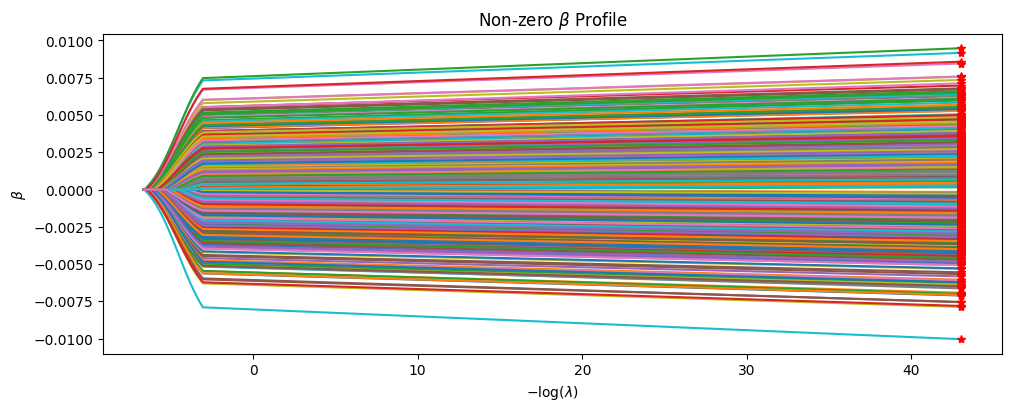

In [306]:
out = out_naive

lmdas = np.concatenate([out['lmdas'], [out['lmdas'][-1] * 1e-20]])
_, axes = plt.subplots(1, 1, layout='constrained', figsize=(10, 4))
for j in tqdm(range(out['betas'].shape[0])):
    beta_j = out['betas'][j]
    if beta_j.count_nonzero() > 0:
        bj = np.array(beta_j.todense()).squeeze()
        bj = np.concatenate([bj, [beta_min_norm_star[j]]])
        axes.plot(-np.log(lmdas), bj)
for j in tqdm(range(beta_min_norm_star.shape[0])):
    axes.plot(-np.log(lmdas[-1]), beta_min_norm_star[j], marker='*', color='red') 
axes.set_title('Non-zero $\\beta$ Profile')
axes.set_xlabel('$-\log(\lambda)$')
axes.set_ylabel('$\\beta$')
plt.show()

In [312]:
y - X @ beta_min_norm_star, beta_min_norm_star

(array([ 1.32982019e-07, -1.46158101e-07,  4.41519755e-07,  8.21936415e-07,
        -2.19076837e-07, -2.78169898e-07, -3.43775375e-07,  1.48055692e-07,
         1.37728189e-06, -3.43701566e-07]),
 array([ 3.82085828e-03, -3.59125977e-03,  2.07271249e-03,  8.92037732e-04,
         0.00000000e+00, -4.22874258e-03,  6.98948169e-04, -2.66206267e-03,
         5.53092351e-04,  3.02349707e-03,  2.97028099e-03, -6.90626768e-04,
        -1.04120593e-03, -4.72679791e-03,  7.45069527e-04, -5.83039250e-03,
         1.28114064e-04,  0.00000000e+00, -8.56276696e-04, -6.43427699e-04,
        -4.92681880e-07, -2.06545445e-03, -2.59207769e-03, -9.25490472e-04,
         0.00000000e+00, -1.92372439e-03,  2.40936881e-03,  4.59988574e-03,
         6.28468345e-03,  0.00000000e+00,  1.54619815e-03,  0.00000000e+00,
         4.90108930e-03, -1.67059177e-03,  0.00000000e+00,  1.81318524e-03,
        -1.69617225e-04,  4.59030744e-03,  1.05249550e-03,  3.49837957e-03,
         0.00000000e+00,  3.69803540e-03, -1